## Predicting Energy Savings: Optimizing Residential Retrofit Programs

**Problem Statement:**
This project aims to develop a predictive model to estimate the **First Year Modeled Energy Savings ($ Estimate)** for residential energy efficiency projects. The goal is to evaluate how various factors, including project costs, retrofitting measures, and customer characteristics, influence energy savings in dollar terms. This will help optimize energy efficiency programs and better allocate resources for maximum impact.

**Use Case:**
The model will assist energy program managers and policymakers in assessing the effectiveness of energy efficiency incentives and retrofitting strategies. By understanding the relationship between project characteristics and energy savings, decision-makers can:
1. Improve subsidy designs by identifying impactful factors.
2. Optimize resource allocation for higher returns on investment.
3. Support households in achieving cost-effective energy savings.

**Assumption:**
The target variable, First Year Modeled Energy Savings ($ Estimate), is modeled based on estimated post-retrofit energy savings in dollars. This analysis assumes that energy prices remain constant across projects because the dataset does not include dynamic energy pricing information, making it necessary to simplify the relationship between energy consumption savings and dollar savings.

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

In [4]:
from pathlib import Path
import tarfile
import urllib.request

def load_csv(file_path):
    csv_path = Path(file_path)
    if not csv_path.is_file():
        print("File not found!")
        return None
    return pd.read_csv(csv_path)

file_path = r"C:\MMA\Winter 2025\INSY 695 - Production\Assignment 1\Residential_Existing_Homes__One_to_Four_Units.csv"
df = load_csv(file_path)

## Loading and Exploring the data

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.head()

,Reporting Period,Home Performance Project ID,Home Performance Site ID,Project County,Project City,Project Zip,Gas Utility,Electric Utility,Project Completion Date,Customer Type,Low-Rise or Home Performance Indicator,Total Project Cost,Total Incentives,Type of Program Financing,Amount Financed Through Program,Pre-Retrofit Home Heating Fuel Type,Year Home Built,Size of Home,Volume of Home,Number of Units,Measure Type,Estimated Annual kWh Savings,Estimated Annual MMBtu Savings,First Year Energy Savings $ Estimate,Homeowner Received Green Jobs-Green NY Free/Reduced Cost Audit (Y/N),New Georeferenced Column
0,06/30/2023,568997,414238,Erie,Eden,14057,NaN,National Grid,02/22/2023,Assisted,Home Performance,5986,2993,NaN,0,NaN,1957,"2,200","17,600",1.0,Building Shell,106,16,495,Y,POINT (-78.89672 42.652845)
1,06/30/2023,558860,395723,Oswego,Fulton,13069,National Grid,National Grid,12/09/2022,Assisted,Home Performance,9780,4090,NaN,0,Natural Gas,1912,"1,024","8,192",1.0,Building Shell,349,19,256,Y,POINT (-76.41174 43.325035)
2,06/30/2023,551162,397589,Jefferson,Watertown,13601,NaN,National Grid,11/28/2022,Assisted,Home Performance,7468,3734,NaN,0,NaN,1965,"1,500","12,000",1.0,Building Shell,2700,0,340,Y,POINT (-75.9049969 43.9757948)
3,06/30/2023,541719,394286,Tioga,Owego,13827,NaN,New York State Electric & Gas,07/13/2022,Assisted,Home Performance,9590,4795,NaN,0,NaN,1976,"1,850","14,800",1.0,Building Shell,0,14,394,Y,POINT (-76.26612 42.105545)
4,06/30/2023,544732,379592,Oneida,Utica,13502,NaN,National Grid,07/11/2022,Assisted,Home Performance,10000,5000,NaN,0,NaN,1925,"1,568","12,544",1.0,Building Shell,0,35,380,Y,POINT (-75.2472726 43.1010822)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71381 entries, 0 to 71380
Data columns (total 26 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   Reporting Period                                                      71381 non-null  object 
 1   Home Performance Project ID                                           71381 non-null  object 
 2   Home Performance Site ID                                              71381 non-null  object 
 3   Project County                                                        71381 non-null  object 
 4   Project City                                                          71381 non-null  object 
 5   Project Zip                                                           71381 non-null  int64  
 6   Gas Utility                                                           52835 non-null  object 


In [7]:
missing_values = df.isnull().sum()
print(missing_values)

Reporting Period                                                            0
Home Performance Project ID                                                 0
Home Performance Site ID                                                    0
Project County                                                              0
Project City                                                                0
Project Zip                                                                 0
Gas Utility                                                             18546
Electric Utility                                                            0
Project Completion Date                                                     0
Customer Type                                                              69
Low-Rise or Home Performance Indicator                                      0
Total Project Cost                                                          0
Total Incentives                                                

In [8]:
# Convert "Year Home Built" to numeric, forcing errors to NaN
df["Year Home Built"] = pd.to_numeric(df["Year Home Built"], errors='coerce')

# Calculate "Age of Home"
current_year = pd.Timestamp.now().year
df["Age of Home"] = 2023 - df["Year Home Built"]

# Display the first few rows to verify the new column
df[["Year Home Built", "Age of Home"]].head()

df=df.drop(columns=['Year Home Built'])

As mentioned under data dictionary, rows missing 'Age of Home', 'Number of Units', 'Size of Home' and 'Volume of Home' were systematically tied to projects completed before January 1, 2018, due to data collection policies in place at the time. These projects represent a distinct subset with limited feature availability. To maintain consistency and focus on projects with complete information, these rows were excluded from the dataset.

Dropping rows with missing values under 'Customer Type' as the number of missing values are insignificant and the accurate input is critical in the causal inference stage.

In [9]:
df = df.dropna(subset=['Age of Home', 'Number of Units', 'Customer Type'])

In [10]:
missing_values = df.isnull().sum()
print(missing_values)

Reporting Period                                                            0
Home Performance Project ID                                                 0
Home Performance Site ID                                                    0
Project County                                                              0
Project City                                                                0
Project Zip                                                                 0
Gas Utility                                                             10745
Electric Utility                                                            0
Project Completion Date                                                     0
Customer Type                                                               0
Low-Rise or Home Performance Indicator                                      0
Total Project Cost                                                          0
Total Incentives                                                

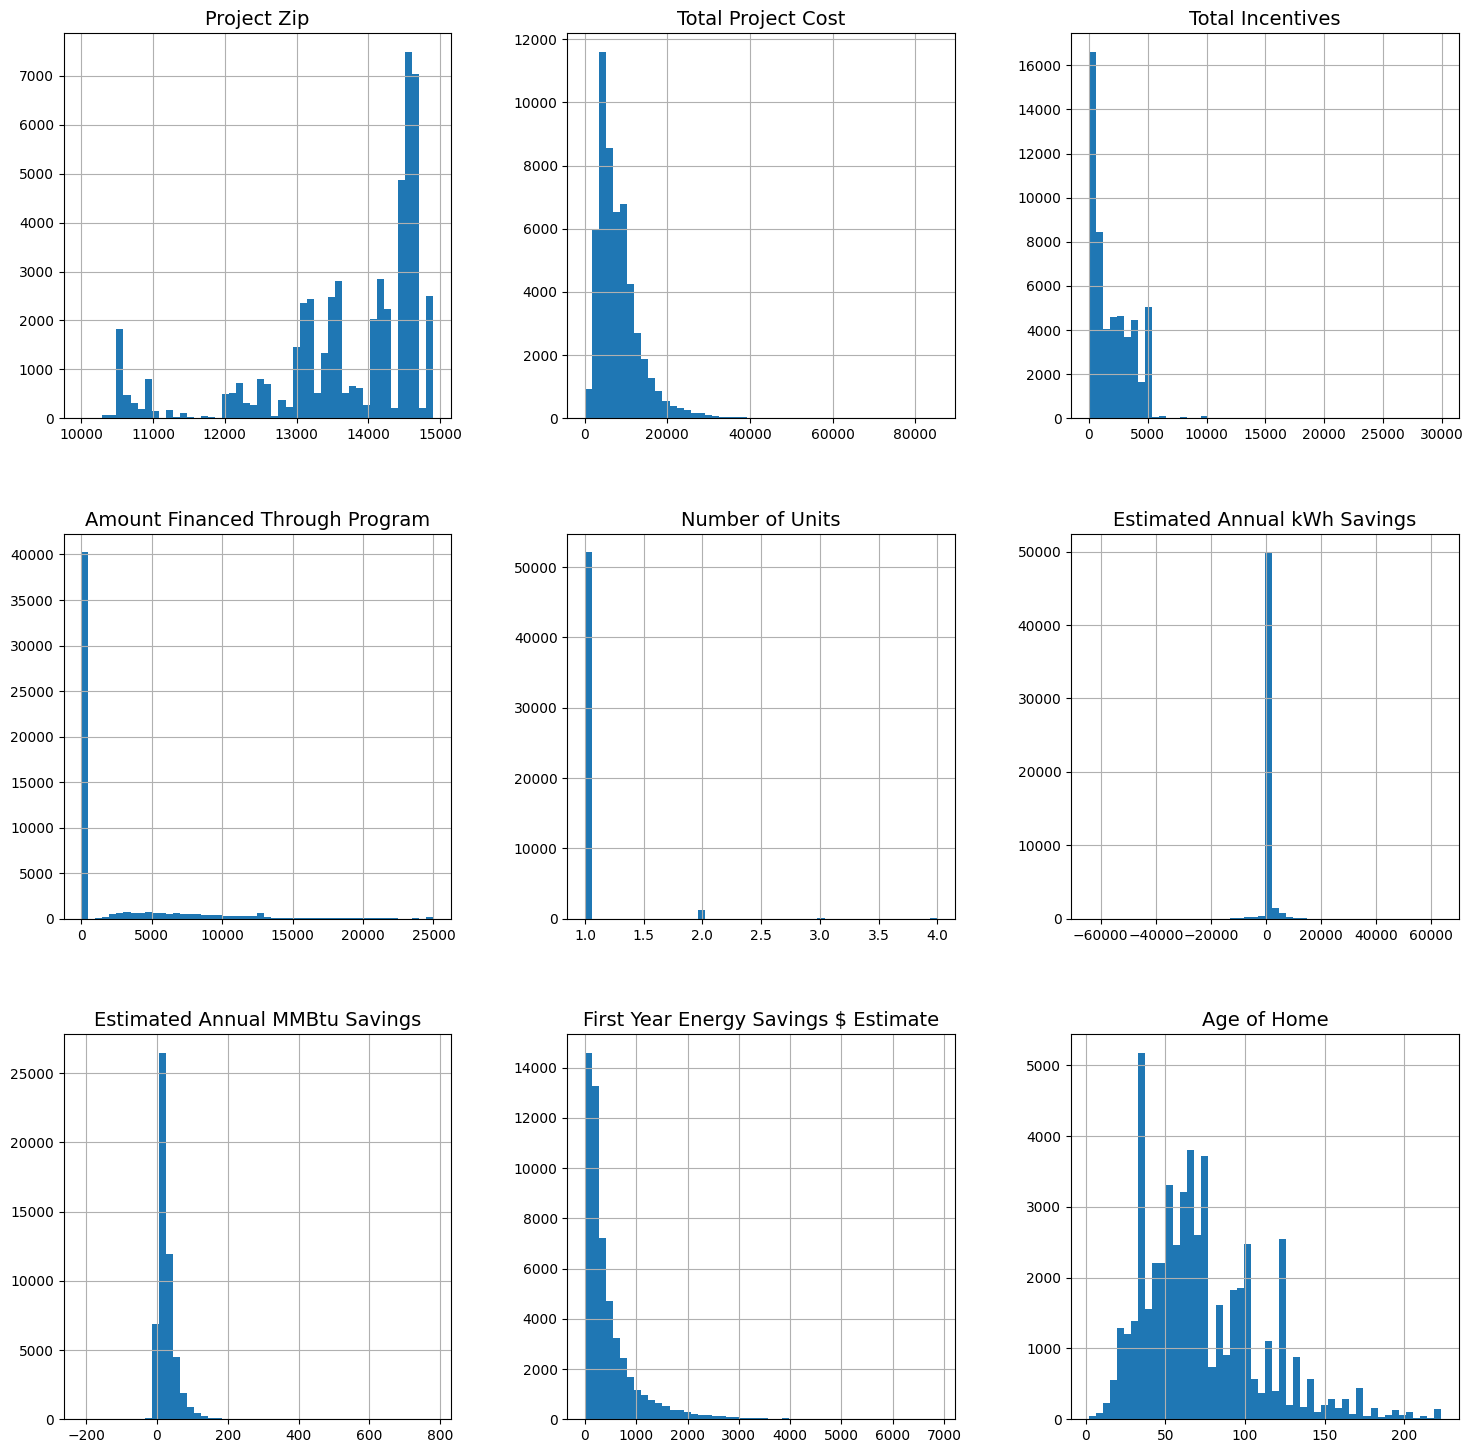

In [11]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(18, 18))
plt.show()

In [12]:
df['Project County'].value_counts()

Project County
Monroe          14412
Erie             5829
Onondaga         4051
Oneida           3285
Jefferson        2966
Westchester      2741
Ontario          2115
Wayne            1447
Tompkins         1313
Niagara          1179
Livingston        997
Broome            871
Dutchess          870
Albany            808
Herkimer          660
Chemung           613
Oswego            604
Steuben           603
Rockland          572
Orange            568
Ulster            555
Madison           468
Cayuga            418
Rensselaer        372
Saratoga          368
Schenectady       323
Genesee           283
St. Lawrence      283
Cortland          260
Otsego            254
Seneca            251
Orleans           233
Chautauqua        223
Franklin          221
Tioga             200
Yates             182
Sullivan          178
Kings             161
Chenango          158
Columbia          148
Wyoming           146
Queens            145
Schuyler          139
Warren            124
Putnam           

In [13]:
# Simplifying the County Column
county_counts = df['Project County'].value_counts()
small_counties = county_counts[county_counts < 1000].index
df['Project County'] = df['Project County'].replace(small_counties, 'Other')

In [14]:
df['Project County'].value_counts()

Project County
Monroe         14412
Other          14319
Erie            5829
Onondaga        4051
Oneida          3285
Jefferson       2966
Westchester     2741
Ontario         2115
Wayne           1447
Tompkins        1313
Niagara         1179
Name: count, dtype: int64

In [15]:
def convert_size_of_home(size):
    if isinstance(size, str):
        if 'SF Below 800' in size:
            return np.nan
        elif 'SF Above 4,000' in size:
            return np.nan
        else:
            try:
                return float(size.replace(',', ''))
            except ValueError:
                return np.nan
    else:
        return size

df['Size of Home'] = df['Size of Home'].apply(convert_size_of_home)

In [16]:
# Function to convert 'Volume of Home' values
def convert_volume_of_home(volume):
    if isinstance(volume, str):
        if volume == 'Good':
            return np.nan
        else:
            try:
                return float(volume.replace(',', ''))
            except ValueError:
                return np.nan
    else:
        return volume

# Apply the conversion function to the 'Volume of Home' column
df['Volume of Home'] = df['Volume of Home'].apply(convert_volume_of_home)

Checking the distribution of some potential stratification columns

In [17]:
print(df['Number of Units'].value_counts())
print(df["Pre-Retrofit Home Heating Fuel Type"].value_counts())
print(df["Low-Rise or Home Performance Indicator"].value_counts())

Number of Units
1.0    52125
2.0     1227
3.0      171
4.0      134
Name: count, dtype: int64
Pre-Retrofit Home Heating Fuel Type
Natural Gas        25153
Natural gas        14918
Oil                 7002
Propane             2784
Electricity         1087
Wood                 410
Wood Pellets         145
Kerosene             128
Coal                  32
Bituminous Coal        7
Anthracite Coal        5
Electric               1
Name: count, dtype: int64
Low-Rise or Home Performance Indicator
Home Performance    48738
Low-Rise             4919
Name: count, dtype: int64


In [18]:
df["Pre-Retrofit Home Heating Fuel Type"].replace('Electric', 'Electricity', inplace=True)
print(df["Pre-Retrofit Home Heating Fuel Type"].value_counts())

Pre-Retrofit Home Heating Fuel Type
Natural Gas        25153
Natural gas        14918
Oil                 7002
Propane             2784
Electricity         1088
Wood                 410
Wood Pellets         145
Kerosene             128
Coal                  32
Bituminous Coal        7
Anthracite Coal        5
Name: count, dtype: int64


C:\Users\melam\AppData\Local\Temp\ipykernel_19216\1922190732.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Pre-Retrofit Home Heating Fuel Type"].replace('Electric', 'Electricity', inplace=True)


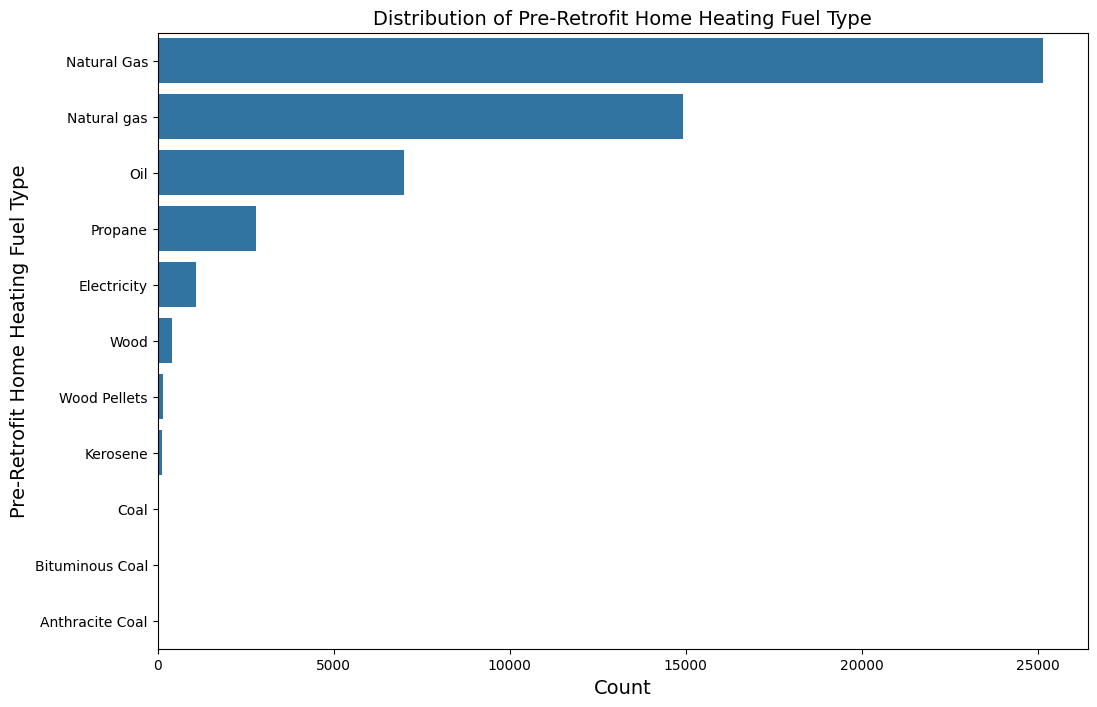

In [19]:
plt.figure(figsize=(12, 8))
sns.countplot(y="Pre-Retrofit Home Heating Fuel Type", data=df, order=df["Pre-Retrofit Home Heating Fuel Type"].value_counts().index)
plt.title("Distribution of Pre-Retrofit Home Heating Fuel Type")
plt.xlabel("Count")
plt.ylabel("Pre-Retrofit Home Heating Fuel Type")
plt.show()

Observation: Conducting a stratified split based on the 'Pre-Retrofit Home Heating Fuel Type' column, as it is likely to have a significant impact on energy savings (Fuel conversions (e.g., switching from oil to electricity) can cause significant changes in savings). Prior to splitting, filling the missing values in the column with a placeholder value (e.g., "Unknown").

In [20]:
df["Pre-Retrofit Home Heating Fuel Type"].fillna("Unknown", inplace=True)


C:\Users\melam\AppData\Local\Temp\ipykernel_19216\2036107093.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Pre-Retrofit Home Heating Fuel Type"].fillna("Unknown", inplace=True)


## Examining Correlations

In [21]:
corr_matrix = df.corr(numeric_only=True)

In [22]:
corr_matrix['First Year Energy Savings $ Estimate'].sort_values(ascending=False)

First Year Energy Savings $ Estimate    1.000000
Estimated Annual MMBtu Savings          0.653646
Total Project Cost                      0.552391
Amount Financed Through Program         0.454514
Size of Home                            0.240263
Volume of Home                          0.215440
Age of Home                             0.199628
Total Incentives                        0.165558
Estimated Annual kWh Savings            0.160511
Number of Units                         0.020673
Project Zip                            -0.355112
Name: First Year Energy Savings $ Estimate, dtype: float64

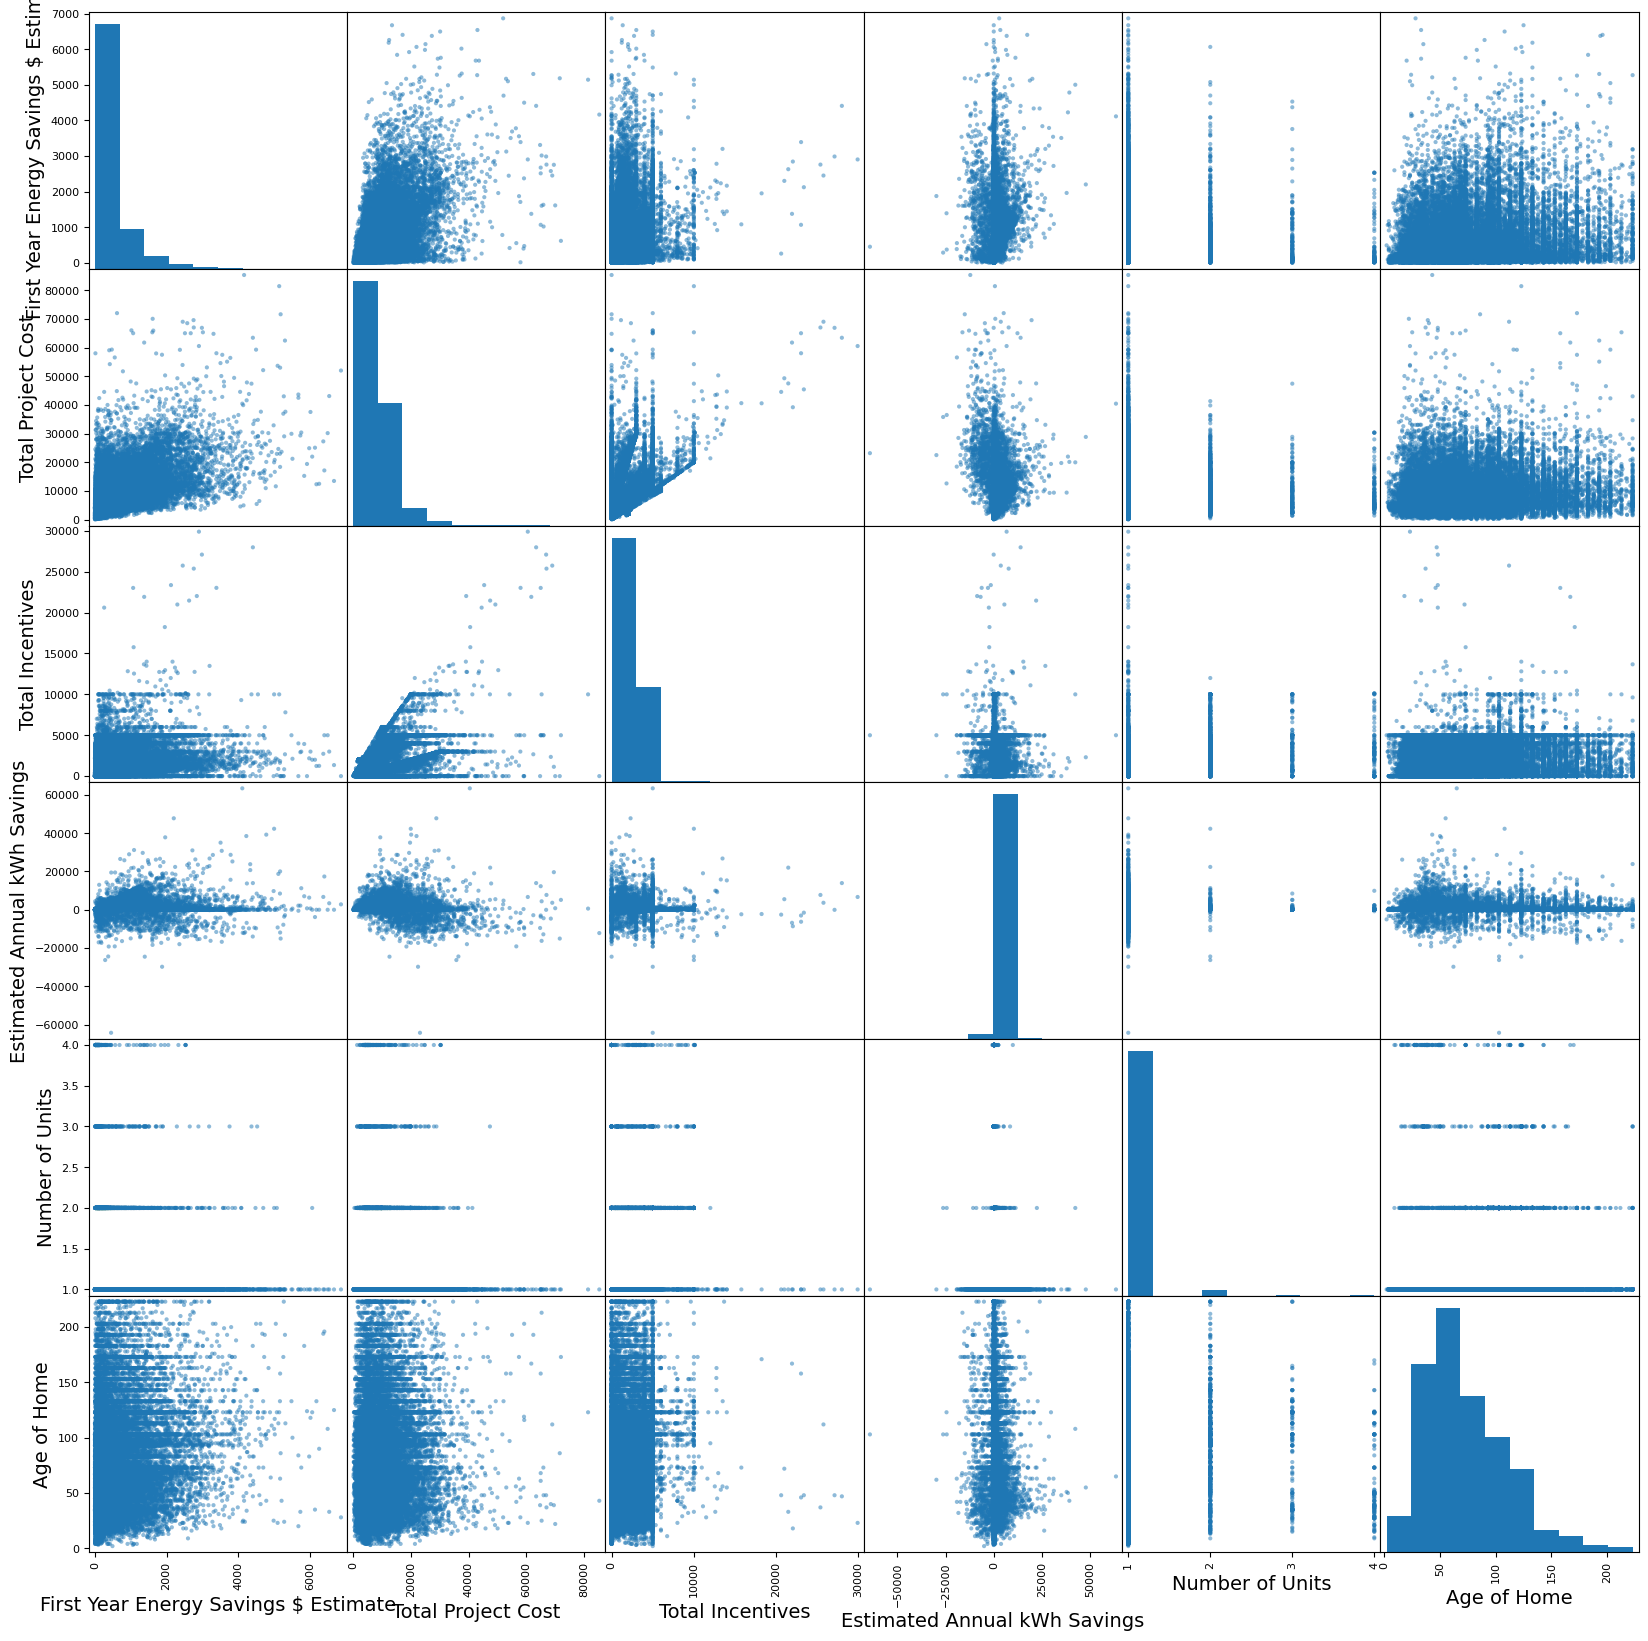

In [23]:
from pandas.plotting import scatter_matrix

attributes = ["First Year Energy Savings $ Estimate", "Total Project Cost", 
              'Total Incentives', 'Estimated Annual kWh Savings', 'Number of Units', 'Age of Home']
scatter_matrix(df[attributes], figsize=(20, 20))
plt.show()

In [24]:
zero_incentives_by_customer_type = df[df['Total Incentives'] == 0].groupby('Customer Type').size()
print(zero_incentives_by_customer_type)

Customer Type
Assisted      10
Market      9454
dtype: int64


In [25]:
zero_incentives_by_customer_type = df[df['Amount Financed Through Program'] == 0].groupby('Customer Type').size()
print(zero_incentives_by_customer_type)

Customer Type
Assisted    22410
Market      17838
dtype: int64


# Custom transformer to add new features

- Creating Interaction Term between 'Total Incentives' and 'Customer Type' to allow the model to learn (i) the effect of receiving any incentive and (ii) the additional impact of incentive amount.

- Creating Interaction Term between 'Program_Financing_Used' and 'Amount Financed Through Program' to allow the model to learn (i) the effect of receiving program financing.

In [26]:
# Custom transformer to add new features
class FeatureAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Convert Customer Type to numeric
        X['Customer_Type_Num'] = X['Customer Type'].apply(lambda x: 1 if x == 'Assisted' else 0)

        # Create the interaction term
        X['Incentive_Customer_Interaction'] = X['Total Incentives'] * X['Customer_Type_Num']

        # Create binary indicator for whether program financing was used
        X['Program_Financing_Used'] = X['Type of Program Financing'].notnull().astype(int)

        # Interaction with Amount Financed
        X['Financing_Amount_Interaction'] = X['Program_Financing_Used'] * X['Amount Financed Through Program']

        return X

## Outlier Examination
Applying Isolation Forest for outlier detection on 'Total Project Cost' as applying on all predictors might result in false positives due to features with zero (incentives and program financing)

In [27]:
# Extract feature as a 2D array
feature = df[["Total Project Cost"]].values  # Use double brackets to ensure it's 2D

# Initialize Isolation Forest
isolation_forest = IsolationForest(contamination=0.1, random_state=42)

# Fit the model and predict outliers
outlier_pred = isolation_forest.fit_predict(feature)

In [28]:
# Add outlier prediction to the DataFrame
df['Outlier'] = (outlier_pred == -1).astype(int)

# Separate outliers and non-outliers
outliers = df[df['Outlier'] == 1]
non_outliers = df[df['Outlier'] == 0]

# Check the number of outliers
print(f"Number of outliers: {outliers.shape[0]}")


Number of outliers: 5366


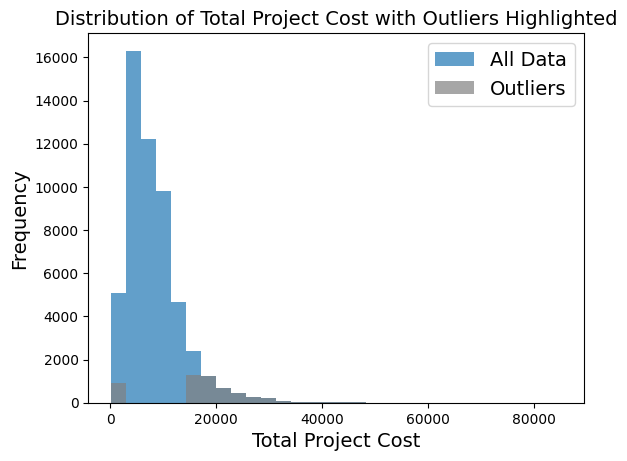

In [29]:
import matplotlib.pyplot as plt

plt.hist(df['Total Project Cost'], bins=30, alpha=0.7, label='All Data')
plt.hist(outliers['Total Project Cost'], bins=30, alpha=0.7, label='Outliers', color='grey')
plt.legend()
plt.xlabel('Total Project Cost')
plt.ylabel('Frequency')
plt.title('Distribution of Total Project Cost with Outliers Highlighted')
plt.show()


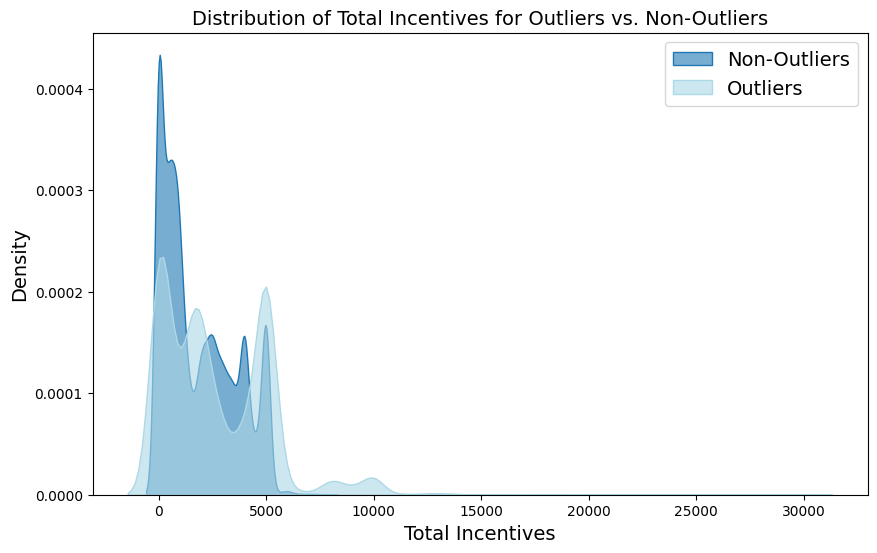

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distributions of a key predictor (example: Total Incentives)
plt.figure(figsize=(10, 6))
sns.kdeplot(non_outliers['Total Incentives'], label='Non-Outliers', fill=True, alpha=0.6)
sns.kdeplot(outliers['Total Incentives'], label='Outliers', fill=True, color='lightblue', alpha=0.6)
plt.title('Distribution of Total Incentives for Outliers vs. Non-Outliers')
plt.xlabel('Total Incentives')
plt.ylabel('Density')
plt.legend()
plt.show()


In [31]:
df['Total Project Cost'].describe()

count    53657.000000
mean      8180.470023
std       5511.254958
min         95.000000
25%       4600.000000
50%       6850.000000
75%      10279.000000
max      85290.000000
Name: Total Project Cost, dtype: float64

In [32]:
high_incentive_outliers = outliers[outliers['Total Incentives'] > 10000]
print(high_incentive_outliers[['Total Project Cost']].describe())

       Total Project Cost
count           43.000000
mean         41095.441860
std          13257.976965
min          21200.000000
25%          30342.000000
50%          39286.000000
75%          46462.500000
max          69000.000000


In [33]:
low_cost_outliers = outliers[outliers['Total Project Cost'] < 1000]
print(low_cost_outliers[['Total Incentives']].describe())

       Total Incentives
count        222.000000
mean         144.729730
std          154.934401
min            0.000000
25%           44.250000
50%           80.000000
75%          218.500000
max          498.000000


Observation: The outliers reflect valid scenarios, as higher costs are associated with higher incentives and the same applies to lower values. Therefore, they will be retained in the dataset.

Excluding columns that won't contribute meaningfully to the model. Also, the columns 'Estimated Annual kWh Savings' and 'Estimated Annual MMBtu Savings' are dropped to avoid data leakage, as they directly contribute to the computation of the target variable,'First Year Modeled Energy Savings $ Estimate'.

In [34]:
df = df.drop(columns=['Reporting Period', 'Home Performance Project ID', 'Home Performance Site ID', 'Project City', 'Project Zip', 'Project Completion Date', 'Homeowner Received Green Jobs-Green NY Free/Reduced Cost Audit (Y/N)','New Georeferenced Column', 'Outlier', 'Estimated Annual MMBtu Savings', 'Estimated Annual kWh Savings'])

In [35]:
# Separate the target variable
target_variable = 'First Year Energy Savings $ Estimate'
X = df.drop(columns=[target_variable])
y = df[target_variable]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X["Pre-Retrofit Home Heating Fuel Type"], random_state=42)

print(X_test["Pre-Retrofit Home Heating Fuel Type"].value_counts() / len(X_test))

Pre-Retrofit Home Heating Fuel Type
Natural Gas        0.468785
Natural gas        0.278047
Oil                0.130451
Propane            0.051901
Unknown            0.036992
Electricity        0.020313
Wood               0.007641
Wood Pellets       0.002702
Kerosene           0.002423
Coal               0.000559
Bituminous Coal    0.000093
Anthracite Coal    0.000093
Name: count, dtype: float64


In [37]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42925 entries, 20715 to 29137
Data columns (total 15 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Project County                          42925 non-null  object 
 1   Gas Utility                             34319 non-null  object 
 2   Electric Utility                        42925 non-null  object 
 3   Customer Type                           42925 non-null  object 
 4   Low-Rise or Home Performance Indicator  42925 non-null  object 
 5   Total Project Cost                      42925 non-null  int64  
 6   Total Incentives                        42925 non-null  int64  
 7   Type of Program Financing               10936 non-null  object 
 8   Amount Financed Through Program         42925 non-null  int64  
 9   Pre-Retrofit Home Heating Fuel Type     42925 non-null  object 
 10  Size of Home                            41328 non-null  flo

## Transformation Pipeline

In [38]:
# Apply FeatureAdder before other transformations
feature_adder_pipeline = Pipeline([
    ('feature_adder', FeatureAdder()),
])

# First, apply the feature adder pipeline to the training data
X_train_added_features = feature_adder_pipeline.fit_transform(X_train)
X_test_added_features = feature_adder_pipeline.transform(X_test)

# Verify the new features added
print("X_train with added features:\n", X_train_added_features[:5])

X_train with added features:
       Project County                     Gas Utility  \
20715          Other   New York State Electric & Gas   
61977       Onondaga                   National Grid   
9322            Erie  National Fuel Gas Distribution   
55925           Erie  National Fuel Gas Distribution   
28116         Monroe        Rochester Gas & Electric   

                    Electric Utility Customer Type  \
20715  New York State Electric & Gas      Assisted   
61977                  National Grid      Assisted   
9322                   National Grid      Assisted   
55925                  National Grid        Market   
28116       Rochester Gas & Electric      Assisted   

      Low-Rise or Home Performance Indicator  Total Project Cost  \
20715                       Home Performance               14060   
61977                       Home Performance                9014   
9322                        Home Performance               14588   
55925                       Home Per

In [39]:
# Numerical pipeline (imputing missing values with the median)
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
])

# Categorical pipeline (imputing missing values with the most frequent value, then encoding)
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
])

# Combine custom transformers with existing numerical and categorical pipelines
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, [
        'Size of Home', 'Volume of Home', 'Total Project Cost', 
        'Total Incentives', 'Amount Financed Through Program', 
        'Number of Units', 'Age of Home',
        'Incentive_Customer_Interaction', 'Financing_Amount_Interaction'
    ]),
    ("cat", cat_pipeline, [
        'Project County', 'Gas Utility', 'Electric Utility', 
        'Customer Type', 'Low-Rise or Home Performance Indicator', 
        'Pre-Retrofit Home Heating Fuel Type', 'Measure Type', 
        'Type of Program Financing'
    ]),
])

# Fit and transform the data
X_train_prepared = full_pipeline.fit_transform(X_train_added_features)
X_test_prepared = full_pipeline.transform(X_test_added_features)

# Convert the transformed data back to DataFrame for easier inspection
X_train_prepared_df = pd.DataFrame(X_train_prepared)
X_test_prepared_df = pd.DataFrame(X_test_prepared)

# Verify the new features
print("Transformed X_train:\n", X_train_prepared_df.head())
print("Transformed X_test:\n", X_test_prepared_df.head())

Transformed X_train:
        0        1        2       3        4    5      6       7        8   \
0  2016.0   8064.0  14060.0  4000.0  10060.0  1.0   64.0  4000.0  10060.0   
1  2106.0  16848.0   9014.0  4507.0      0.0  1.0   60.0  4507.0      0.0   
2  1657.0  51624.0  14588.0  7294.0      0.0  4.0  103.0  7294.0      0.0   
3  1840.0  13800.0   6757.0   676.0   6057.0  1.0  104.0     0.0   6057.0   
4   897.0  14592.0   6116.0  1752.0      0.0  1.0   50.0  1752.0      0.0   

    9    10   11   12   13   14   15   16   17   18   19   20   21   22   23  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    24   25   26   27   28   29   

# Training and Evaluating on the Training Set

In [40]:
# Train a Random Forest model
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train_prepared, y_train)

# Evaluate the model
housing_predictions = forest_reg.predict(X_train_prepared)
forest_mse = mean_squared_error(y_train, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

print(f"Random Forest RMSE on training set: {forest_rmse}")

# Cross-validation
forest_scores = cross_val_score(forest_reg, X_train_prepared, y_train,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(forest_rmse_scores)

Random Forest RMSE on training set: 130.49572358546465
Scores: [354.27295924 361.04974819 352.30350072 340.70960436 343.75187199
 351.00222844 360.18120752 333.58516078 338.04731161 355.75413148]
Mean: 349.0657724334581
Standard deviation: 9.013152381877584


Observation: As the model is likely overfitting, examining feature importance below and rerunning the model on high-importance features to see if it generalizes the model.

In [41]:
importances = forest_reg.feature_importances_
feature_names = full_pipeline.get_feature_names_out()

# Create a DataFrame for better visualization
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the features by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(importances_df)

                                              Feature  Importance
2                             num__Total Project Cost    0.303106
52       cat__Pre-Retrofit Home Heating Fuel Type_Oil    0.233312
6                                    num__Age of Home    0.069869
1                                 num__Volume of Home    0.065081
0                                   num__Size of Home    0.051316
3                               num__Total Incentives    0.045521
50  cat__Pre-Retrofit Home Heating Fuel Type_Natur...    0.034812
4                num__Amount Financed Through Program    0.034502
8                   num__Financing_Amount_Interaction    0.032658
7                 num__Incentive_Customer_Interaction    0.014010
31          cat__Gas Utility_Rochester Gas & Electric    0.009074
34          cat__Electric Utility_Consolidated Edison    0.005954
16                          cat__Project County_Other    0.005840
53   cat__Pre-Retrofit Home Heating Fuel Type_Propane    0.005617
37        

In [42]:
# Selected features based on feature importance analysis
selected_features = [
    'Total Project Cost',
    'Pre-Retrofit Home Heating Fuel Type_Oil',
    'Age of Home',
    'Volume of Home',
    'Size of Home',
    'Total Incentives',
    'Pre-Retrofit Home Heating Fuel Type_Natural Gas',
    'Amount Financed Through Program',
    'Financing_Amount_Interaction',
    'Incentive_Customer_Interaction'
]

# Update the pipelines to include only the selected features
num_features = ['Total Project Cost', 'Age of Home', 'Volume of Home', 'Size of Home', 'Total Incentives', 'Amount Financed Through Program', 'Financing_Amount_Interaction', 'Incentive_Customer_Interaction']
cat_features = ['Pre-Retrofit Home Heating Fuel Type']

# Define the numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
])

# Define the categorical pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
])

# Combine the pipelines into a ColumnTransformer
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features),
])

# Apply FeatureAdder before other transformations
feature_adder_pipeline = Pipeline([
    ('feature_adder', FeatureAdder()),
])

# First, apply the feature adder pipeline to the training data
X_train_added_features = feature_adder_pipeline.fit_transform(X_train)
X_test_added_features = feature_adder_pipeline.transform(X_test)

# Fit and transform the data
X_train_prepared = full_pipeline.fit_transform(X_train_added_features)
X_test_prepared = full_pipeline.transform(X_test_added_features)

# Train a Random Forest model with the selected features
forest_reg_selected = RandomForestRegressor(random_state=42)
forest_reg_selected.fit(X_train_prepared, y_train)

# Evaluate the model
housing_predictions_selected = forest_reg_selected.predict(X_train_prepared)
forest_mse_selected = mean_squared_error(y_train, housing_predictions_selected)
forest_rmse_selected = np.sqrt(forest_mse_selected)

print(f"Random Forest RMSE on training set with selected features: {forest_rmse_selected}")

# Cross-validation
forest_scores_selected = cross_val_score(forest_reg_selected, X_train_prepared, y_train,
                                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores_selected = np.sqrt(-forest_scores_selected)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(forest_rmse_scores_selected)

Random Forest RMSE on training set with selected features: 135.43390463241627
Scores: [369.12896887 375.91515973 362.07682785 354.73357429 359.07605668
 367.4616403  369.44143909 346.75657404 347.61927363 373.93059082]
Mean: 362.61401052941034
Standard deviation: 9.842514523662798


## Fine tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Instantiate the model
forest_reg = RandomForestRegressor(random_state=42)

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=forest_reg, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_prepared, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best parameters found: ", best_params)
print("Best estimator found: ", best_estimator)